In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import math
import numpy as np
import torch
import torch.nn as nn
import sklearn.datasets
from torchsummary import summary

from tqdm.auto import tqdm

In [3]:
# Based on https://www.tensorflow.org/tutorials/understanding/sngp?hl=en

In [21]:
plt.rcParams["figure.dpi"] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(
    vmin=0,
    vmax=1,
)
DEFAULT_N_GRID = 100

In [22]:
def make_training_data(sample_size=500):
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
        n_samples=2 * sample_size, noise=0.1
    )

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

In [23]:
def make_testing_data(
    x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID
):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

In [24]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

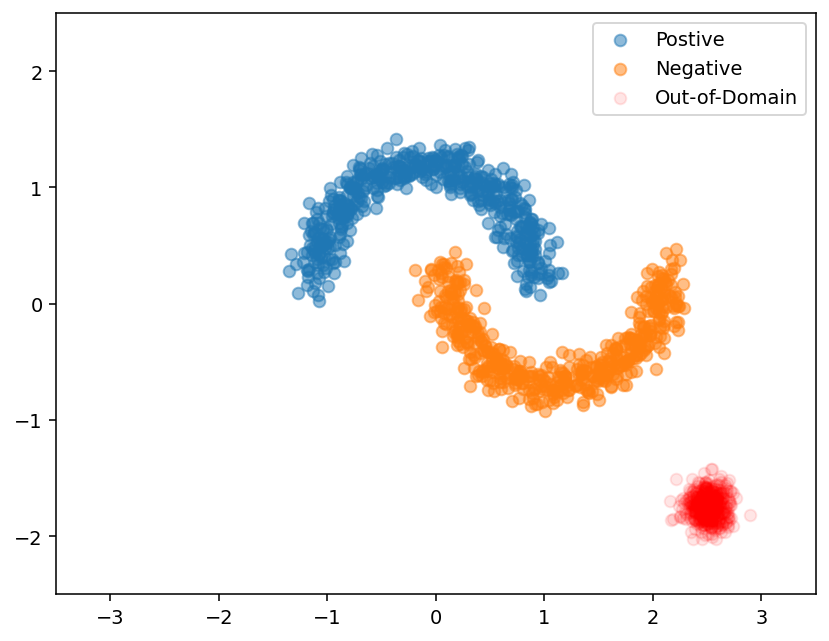

In [25]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="C0", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="C1", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

1. SNGP on ImageNet ([here](https://github.com/google/uncertainty-baselines/blob/main/baselines/imagenet/sngp.py#L23)); **NOTE** is important: all classes share the same covariance
2. Random Fourier Features ([here](https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/random_feature.py))
3. Mean Field Logits ([here](https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/utils.py#L349))

In [76]:
test_torch = (
    torch.from_numpy(test_examples[..., None, None])
    .to(torch.float32)
    .expand(-1, -1, 32, 32)
)
test_torch.shape

torch.Size([10000, 2, 32, 32])

In [122]:
from sngp_pytorch.utils import get_resnet
from sngp_pytorch import RandomFeatureGaussianProcess
from collections import OrderedDict

In [123]:
backbone = get_resnet(
    out_features=128, n_ch=16, last_shape=(1, 1), use_sn=True, input_planes=2
)

model = RandomFeatureGaussianProcess(128, 2, backbone=backbone, verbose=True)

In [124]:
summary(model, test_torch[:5])
;

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
├─Sequential: 1-2                        [-1, 1024]                --
├─Sequential: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 1024]                (recursive)
├─ResNet: 1-3                            [-1, 128]                 --
├─Sequential: 1                          []                        --
|    └─ResNet: 2-2                       [-1, 128]                 (recursive)
├─Sequential: 1                          []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ResNet: 3-1                  [-1, 128]                 (recursive)
├─ResNet: 1                              []                        --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          1,152
├─Sequential: 1                          []            

''

In [125]:
model.compute_covariance(test_torch[:500])

  0%|          | 0/1 [00:00<?, ?it/s]

In [126]:
model.covariance

Parameter containing:
tensor([[ 2.5449e+00, -1.5337e+00, -8.4745e-03,  ...,  3.5610e-05,
          2.9493e-04,  1.1779e-03],
        [-1.5337e+00,  2.1372e+00,  1.0403e-02,  ...,  1.4305e-05,
          5.1171e-05,  2.4429e-04],
        [-8.4745e-03,  1.0403e-02,  1.7633e-03,  ...,  1.3842e-06,
          1.0437e-05,  4.2307e-05],
        ...,
        [ 3.5610e-05,  1.4305e-05,  1.3842e-06,  ...,  2.0041e-03,
         -2.6372e-05,  6.7869e-03],
        [ 2.9493e-04,  5.1171e-05,  1.0437e-05,  ..., -2.6372e-05,
          1.4157e-02,  4.8126e-02],
        [ 1.1779e-03,  2.4429e-04,  4.2307e-05,  ...,  6.7869e-03,
          4.8126e-02,  1.9761e-01]])

In [127]:
model(test_torch[:5], with_variance=True)

(tensor([[-0.5699,  0.3145],
         [-0.5316,  0.3025],
         [-0.5782,  0.3199],
         [-0.6464,  0.3428],
         [-0.6172,  0.3521]], grad_fn=<DivBackward0>),
 tensor([0.3204, 0.4343, 0.2723, 0.0414, 0.1077]))